In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import zscore
import matplotlib.pyplot as plt 
from statsmodels import regression
from statsmodels.tsa.stattools import coint

In [2]:
data = pd.read_excel('dados_relatorio_final.xlsx')

In [3]:
data.head()

,time,IBOV,ABEV3,BBAS3,BBDC3,BBDC4,BBSE3,BRAP4,BRFS3,BRKM5,...,RAIL3,SANB11,SBSP3,SMLS3,TIMP3,UGPA3,USIM5,VALE3,VIVT4,WEGE3
0,2017-01-02,59589,15.09,24.18,15.98,15.94,20.38,12.60,47.90,30.82,...,6.12,24.27,25.46,36.27,7.21,31.13,3.96,22.79,34.80,10.99
1,2017-01-03,61814,15.39,25.28,16.63,16.62,21.11,13.13,49.50,32.58,...,6.19,25.13,25.76,38.38,7.52,31.63,4.17,23.80,35.16,11.54
2,2017-01-04,61589,15.27,25.15,16.62,16.51,21.78,12.85,48.91,32.03,...,6.19,25.25,26.50,38.46,7.67,31.13,4.42,23.37,35.01,11.26
3,2017-01-05,62071,15.36,25.09,16.72,16.69,21.34,13.49,48.53,32.41,...,6.20,25.17,26.58,38.32,7.77,31.31,4.47,24.26,34.42,11.23
4,2017-01-06,61665,15.23,25.36,16.84,16.80,21.01,13.25,46.22,31.77,...,6.36,25.06,26.19,36.62,7.67,31.17,4.34,23.61,34.51,11.33


In [58]:
class senninha_long_and_short():
    def __init__(self,dados,t1,t2, financeiro_inicial):
        #temos o par de tickers, os dados históricos de preço, e as variações históricas.
        self.t1, self.t2 = t1,t2
        self.dados = dados[['time',t1,t2]]
        self.dados_var = dados[[t1,t2]].pct_change()[1:]
        self.dados = self.dados[1:]
        self.s1, self.s2 = self.dados[self.t1], self.dados[self.t2]
        self.s1_var, self.s2_var = self.dados_var[self.t1], self.dados_var[self.t2]
        self.financeiro = financeiro_inicial
        #variaveis iniciais para tradar pares
        self.posicionado = 0
        self.compra_s1 = 0
        self.venda_s2 = 0
        #desempenho ao longo do tempo 
        self.l_resultado = []
          
    def calcula_zscore_spread(self,stock1,stock2):
        stock1 = sm.add_constant(stock1)
        results = sm.OLS(stock2,stock1).fit()
        stock1 = stock1[self.t1]
        b = results.params[self.t1]
        spread = stock2 - (b*stock1)
        zs = zscore(spread)[-1]
        return zs, b
    
    def condicoes_operar(self, zs_atual, zs_critico, cotacao1, cotacao2):
        if zs_atual >= zs_critico and self.posicionado == 0:
            razao = cotacao1/cotacao2
            volume = (self.financeiro/2)//cotacao1
            self.v1, self.v2 = int(volume), int(razao*volume)
            #definiu o numero de ações que comprará de cada
            self.venda_s1  = cotacao1*self.v1
            self.compra_s2 = cotacao2*self.v2 
            #print(f'entrou | s1 {self.compra_s1:.2f} | s2 {self.venda_s2:.2f}')
            self.posicionado = 1
        elif zs_atual <= 0.08 and self.posicionado == 1:
            self.posicionado = 0            
            #encerra posicao
            self.compra_s1 = cotacao1*self.v1
            self.venda_s2  = cotacao2*self.v2 
            #print(f'saiu   | s1 {self.venda_s1:.2f} | s2 {self.compra_s2:.2f}')
            #resultado
            resultado_short  = self.venda_s1 - self.compra_s1
            resultado_long   = self.venda_s2 - self.compra_s2
            resultado = resultado_long + resultado_short
            self.l_resultado.append(resultado)
            #print(f'result | s1 {resultado_long:.2f} | s2 {resultado_short:.2f} | l/p = {resultado:.2f}\n')
            self.financeiro += resultado
            #reseta valor em carteira de cada ação
            self.compra_s1, self.venda_s1, self.compra_s2 ,self.venda_s2,  = 0, 0, 0, 0
            resultado, resultado_long, resultado_short = 0, 0, 0
            
    def loop_operador(self, window_size):
        c = 0
        zs_limite = 1.1
        for index in range(window_size, len(self.s1)):
            #stock data in the window range
            s1_var_w, s2_var_w = self.s1_var[c:index], self.s2_var[c:index]
            preco_s1, preco_s2 = self.s1[self.dados.index == index].values[0], self.s2[self.dados.index == index].values[0]
            #calculates the zscore of the spread
            resultado_funcao = self.calcula_zscore_spread(s1_var_w, s2_var_w)
            zs, beta = resultado_funcao[0], resultado_funcao[1]
            self.condicoes_operar(zs_atual=zs, zs_critico=zs_limite, cotacao1=preco_s1, cotacao2=preco_s2)
            c+=1


In [79]:
objitsavale = senninha_long_and_short(data,'VALE3', 'ITSA4', 1000,zs_l=1.1)

In [80]:
objitsavale.loop_operador(window_size=45)

In [81]:
objitsavale.financeiro

943.8100000000001

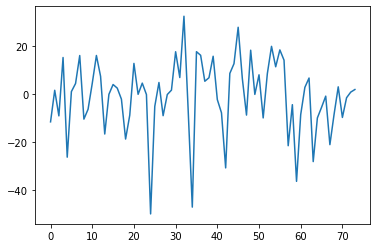

In [82]:
plt.plot(objitsavale.l_resultado)
plt.show()

In [63]:
data.columns

Index(['time', 'IBOV', 'ABEV3', 'BBAS3', 'BBDC3', 'BBDC4', 'BBSE3', 'BRAP4',
       'BRFS3', 'BRKM5', 'BRML3', 'B3SA3', 'CCRO3', 'CIEL3', 'CMIG4', 'CPFE3',
       'CPLE6', 'CSAN3', 'CSNA3', 'CYRE3', 'ECOR3', 'EGIE3', 'ELET3', 'EMBR3',
       'ENBR3', 'EQTL3', 'YDUQ3', 'SUZB3', 'GGBR4', 'GOAU4', 'HYPE3', 'ITSA4',
       'ITUB4', 'JBSS3', 'KLBN11', 'COGN3', 'LAME4', 'LREN3', 'MRFG3', 'MRVE3',
       'MULT3', 'NTCO3', 'PETR3', 'PETR4', 'QUAL3', 'RADL3', 'RENT3', 'RAIL3',
       'SANB11', 'SBSP3', 'SMLS3', 'TIMP3', 'UGPA3', 'USIM5', 'VALE3', 'VIVT4',
       'WEGE3'],
      dtype='object')

In [64]:
lt = [['ABEV3', 'BBAS3'], ['BBDC3', 'BBDC4'],['BBSE3', 'BRAP4'],['BRFS3', 'BRKM5'], ['BRML3', 'B3SA3'], ['CCRO3', 'CIEL3'], ['CMIG4', 'CPFE3'],['CPLE6', 'CSAN3'], ['CSNA3', 'CYRE3'], ['ECOR3', 'EGIE3'], ['ELET3', 'EMBR3'],['ENBR3', 'EQTL3']]

In [66]:
for i in lt:
    objitsavale = senninha_long_and_short(data,i[1], i[0], 1000)
    objitsavale.loop_operador(window_size=45)
    print(i, objitsavale.financeiro)
    

['ABEV3', 'BBAS3'] 817.7299999999999
['BBDC3', 'BBDC4'] 912.1299999999999
['BBSE3', 'BRAP4'] 886.5700000000006
['BRFS3', 'BRKM5'] 1103.0099999999995
['BRML3', 'B3SA3'] 874.1800000000012
['CCRO3', 'CIEL3'] 1064.6500000000003
['CMIG4', 'CPFE3'] 1053.6300000000008
['CPLE6', 'CSAN3'] 996.24
['CSNA3', 'CYRE3'] 1046.2199999999998
['ECOR3', 'EGIE3'] 794.8100000000001
['ELET3', 'EMBR3'] 1197.769999999999
['ENBR3', 'EQTL3'] 775.3799999999994


In [53]:
dados2 = pd.read_excel('C:/Users/danie/Desktop/mql_python/todos_diretorios_desenvolvimento_projeto/Relatório 1/dados_relatorio.xlsx')[1:]

In [55]:
lt = [['close ABEV3', 'close BBAS3'], ['close BBDC3', 'close BBDC4'],['close BBSE3', 'close BRAP4'],['close BRFS3', 'close BRKM5'], ['close BRML3', 'close B3SA3'], ['close CCRO3', 'close CIEL3'], ['close CMIG4', 'close CPFE3'],['close CPLE6', 'close CSAN3'], ['close CSNA3', 'close CYRE3'], ['close ECOR3', 'close EGIE3'], ['close ELET3', 'close EMBR3'],['close ENBR3', 'close EQTL3']]

In [57]:
for i in lt:
    try:
        objitsavale = senninha_long_and_short(dados2,i[1], i[0], 1000)
        objitsavale.loop_operador(window_size=45)
        print(i, objitsavale.financeiro)        
    except:
        print('erro com ',i)


['close ABEV3', 'close BBAS3'] 357.8699999999998
['close BBDC3', 'close BBDC4'] 510.6399999999999
['close BBSE3', 'close BRAP4'] 241.89000000000007
['close BRFS3', 'close BRKM5'] 172.77999999999997
['close BRML3', 'close B3SA3'] 201.44000000000017
['close CCRO3', 'close CIEL3'] 128.72000000000043
['close CMIG4', 'close CPFE3'] 111.27000000000012
erro com  ['close CPLE6', 'close CSAN3']
['close CSNA3', 'close CYRE3'] 45.90000000000036


c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in double_scalars


erro com  ['close ECOR3', 'close EGIE3']
['close ELET3', 'close EMBR3'] 71.33000000000011
['close ENBR3', 'close EQTL3'] 234.78000000000108


In [75]:
class senninha_long_and_short():
    def __init__(self,dados,t1,t2, financeiro_inicial, zs_l):
        #temos o par de tickers, os dados históricos de preço, e as variações históricas.
        self.zs_critico = zs_l
        self.t1, self.t2 = t1,t2
        self.dados = dados[['time',t1,t2]]
        self.dados_var = dados[[t1,t2]].pct_change()[1:]
        self.dados = self.dados[1:]
        self.s1, self.s2 = self.dados[self.t1], self.dados[self.t2]
        self.s1_var, self.s2_var = self.dados_var[self.t1], self.dados_var[self.t2]
        self.financeiro = financeiro_inicial
        #variaveis iniciais para tradar pares
        self.posicionado = 0
        self.compra_s1 = 0
        self.venda_s2 = 0
        #desempenho ao longo do tempo 
        self.l_resultado = []
          
    def calcula_zscore_spread(self,stock1,stock2):
        stock1 = sm.add_constant(stock1)
        results = sm.OLS(stock2,stock1).fit()
        stock1 = stock1[self.t1]
        b = results.params[self.t1]
        spread = stock2 - (b*stock1)
        zs = zscore(spread)[-1]
        return zs, b
    
    def condicoes_operar(self, zs_atual, cotacao1, cotacao2):
        if zs_atual >= self.zs_critico and self.posicionado == 0:
            razao = cotacao1/cotacao2
            volume = (self.financeiro/2)//cotacao1
            self.v1, self.v2 = int(volume), int(razao*volume)
            #definiu o numero de ações que comprará de cada
            self.compra_s1 = cotacao1*self.v1
            self.venda_s2  = cotacao2*self.v2 
            #self.financeiro += (self.venda_s2 - self.compra_s1)
            #print(f'entrou | s1 {self.compra_s1:.2f} | s2 {self.venda_s2:.2f}')
            self.posicionado = 1
        elif zs_atual <= 0.08 and self.posicionado == 1:
            self.posicionado = 0            
            #encerra posicao
            self.venda_s1 = cotacao1*self.v1
            self.compra_s2  = cotacao2*self.v2 
            #self.financeiro += (self.venda_s1 - self.compra_s2)
            #print(f'saiu   | s1 {self.venda_s1:.2f} | s2 {self.compra_s2:.2f}')
            #resultado
            resultado_long = self.venda_s1 - self.compra_s1
            resultado_short  = self.venda_s2 - self.compra_s2
            resultado = resultado_long + resultado_short
            self.l_resultado.append(resultado)
            #print(f'result | s1 {resultado_long:.2f} | s2 {resultado_short:.2f} | l/p = {resultado:.2f}\n')
            self.financeiro += resultado
            #reseta valor em carteira de cada ação
            self.compra_s1, self.venda_s1, self.compra_s2 ,self.venda_s2,  = 0, 0, 0, 0
            resultado, resultado_long, resultado_short = 0, 0, 0
            
    def loop_operador(self, window_size):
        c = 0
        for index in range(window_size, len(self.s1)):
            #stock data in the window range
            s1_var_w, s2_var_w = self.s1_var[c:index], self.s2_var[c:index]
            preco_s1, preco_s2 = self.s1[self.dados.index == index].values[0], self.s2[self.dados.index == index].values[0]
            #calculates the zscore of the spread
            resultado_funcao = self.calcula_zscore_spread(s1_var_w, s2_var_w)
            zs, beta = resultado_funcao[0], resultado_funcao[1]
            self.condicoes_operar(zs_atual=zs, cotacao1=preco_s1, cotacao2=preco_s2)
            c+=1


In [76]:
lt = [['ABEV3', 'BBAS3'], ['BBDC3', 'BBDC4'],['BBSE3', 'BRAP4'],['BRFS3', 'BRKM5'], ['BRML3', 'B3SA3'], ['CCRO3', 'CIEL3'], ['CMIG4', 'CPFE3'],['CPLE6', 'CSAN3'], ['CSNA3', 'CYRE3'], ['ECOR3', 'EGIE3'], ['ELET3', 'EMBR3'],['ENBR3', 'EQTL3']]
for i in lt:
    objitsavale = senninha_long_and_short(data,i[1], i[0], 1000)
    objitsavale.loop_operador(window_size=45)
    print(i, objitsavale.financeiro)

TypeError: __init__() missing 1 required positional argument: 'zs_l'

In [77]:
lt = [['ABEV3', 'BBAS3'], ['BBDC3', 'BBDC4'],['BBSE3', 'BRAP4'],['BRFS3', 'BRKM5'], ['BRML3', 'B3SA3'], ['CCRO3', 'CIEL3'], ['CMIG4', 'CPFE3'],['CPLE6', 'CSAN3'], ['CSNA3', 'CYRE3'], ['ECOR3', 'EGIE3'], ['ELET3', 'EMBR3'],['ENBR3', 'EQTL3']]
l_zs = [1,1.5,2]
for zsl in l_zs:
    print(zsl)
    for i in lt:
        objitsavale = senninha_long_and_short(data,i[0], i[1], 1000,zs_l = zsl)
        objitsavale.loop_operador(window_size=45)
        print(i, objitsavale.financeiro)

1
['ABEV3', 'BBAS3'] 1006.8199999999985
['BBDC3', 'BBDC4'] 1058.2299999999993
['BBSE3', 'BRAP4'] 972.8799999999999
['BRFS3', 'BRKM5'] 1038.8400000000013
['BRML3', 'B3SA3'] 1052.460000000001
['CCRO3', 'CIEL3'] 1536.2200000000003
['CMIG4', 'CPFE3'] 782.6999999999991
['CPLE6', 'CSAN3'] 1027.620000000001
['CSNA3', 'CYRE3'] 1110.960000000001
['ECOR3', 'EGIE3'] 1043.0100000000002
['ELET3', 'EMBR3'] 1525.14
['ENBR3', 'EQTL3'] 1264.6100000000008
1.5
['ABEV3', 'BBAS3'] 964.2799999999995
['BBDC3', 'BBDC4'] 1057.7200000000005
['BBSE3', 'BRAP4'] 1057.5799999999995
['BRFS3', 'BRKM5'] 958.5400000000003
['BRML3', 'B3SA3'] 1031.5700000000002
['CCRO3', 'CIEL3'] 1200.0499999999995
['CMIG4', 'CPFE3'] 850.1499999999999
['CPLE6', 'CSAN3'] 1006.2000000000003
['CSNA3', 'CYRE3'] 975.3699999999994
['ECOR3', 'EGIE3'] 1058.0700000000006
['ELET3', 'EMBR3'] 1050.44
['ENBR3', 'EQTL3'] 1078.7899999999995
2
['ABEV3', 'BBAS3'] 893.1999999999998
['BBDC3', 'BBDC4'] 1012.5900000000003
['BBSE3', 'BRAP4'] 1015.760000000000